<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/goldwithmacrov2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed


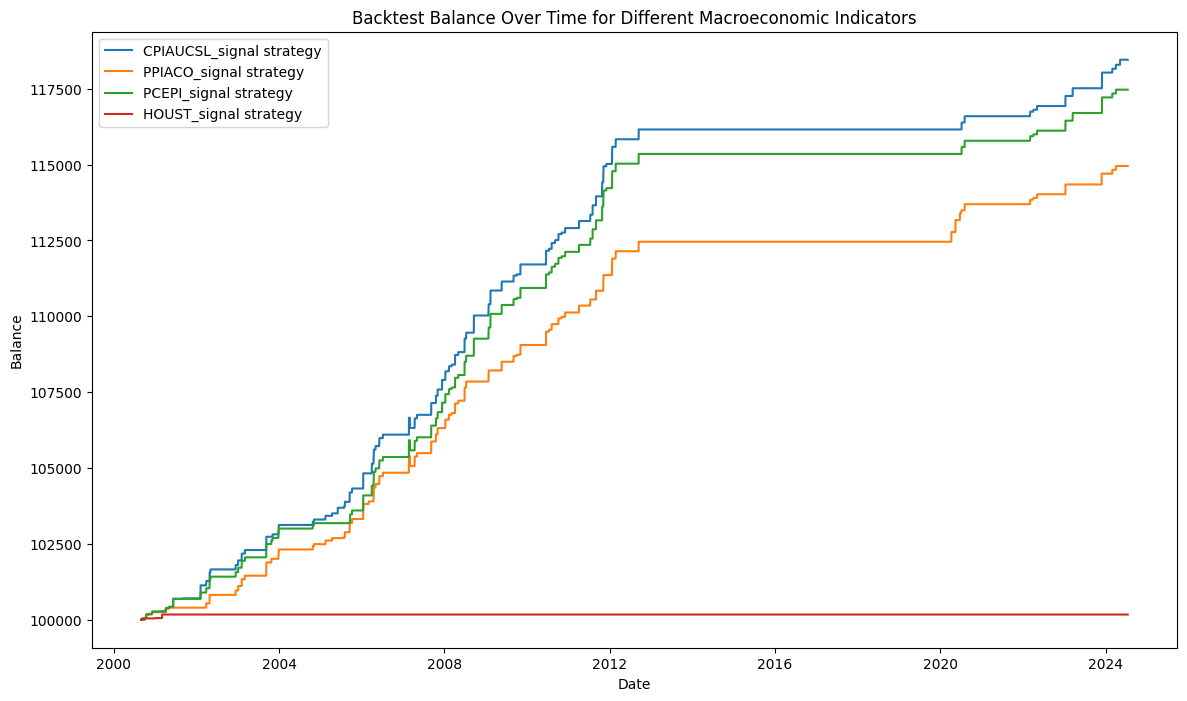

Results for CPIAUCSL_signal strategy:
  Final balance: $118454.04
  Total profit: $18454.04
  Total trades: 88
  Win trades: 85
  Loss trades: 3
  Win percentage: 96.59%
  Highest win: $565.65
  Highest loss: $-334.96
  Max drawdown: 0.31%

Results for PPIACO_signal strategy:
  Final balance: $114951.22
  Total profit: $14951.22
  Total trades: 77
  Win trades: 72
  Loss trades: 4
  Win percentage: 93.51%
  Highest win: $549.94
  Highest loss: $-331.00
  Max drawdown: 0.31%

Results for PCEPI_signal strategy:
  Final balance: $117467.46
  Total profit: $17467.46
  Total trades: 80
  Win trades: 79
  Loss trades: 1
  Win percentage: 98.75%
  Highest win: $561.73
  Highest loss: $-332.64
  Max drawdown: 0.31%

Results for HOUST_signal strategy:
  Final balance: $100171.45
  Total profit: $171.45
  Total trades: 4
  Win trades: 3
  Loss trades: 0
  Win percentage: 75.00%
  Highest win: $116.96
  Highest loss: $inf
  Max drawdown: 0.00%



Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

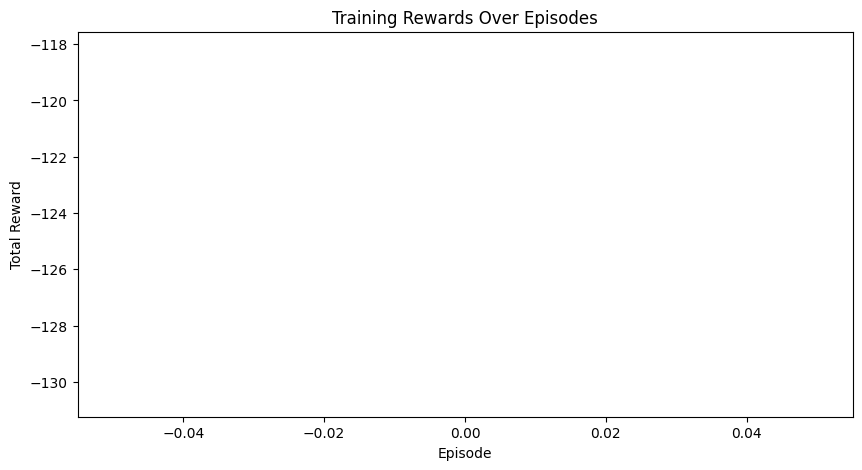

Training Episodes:  10%|█         | 100/1000 [02:58<26:23,  1.76s/it]

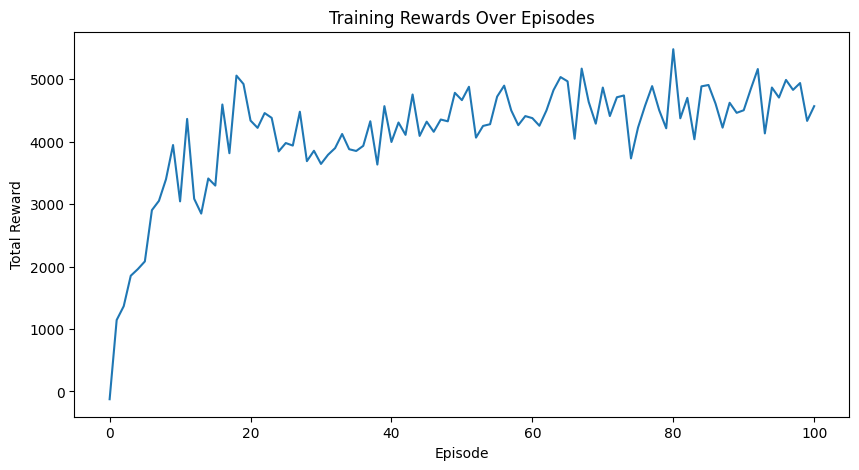

Training Episodes:  20%|██        | 200/1000 [05:51<23:46,  1.78s/it]

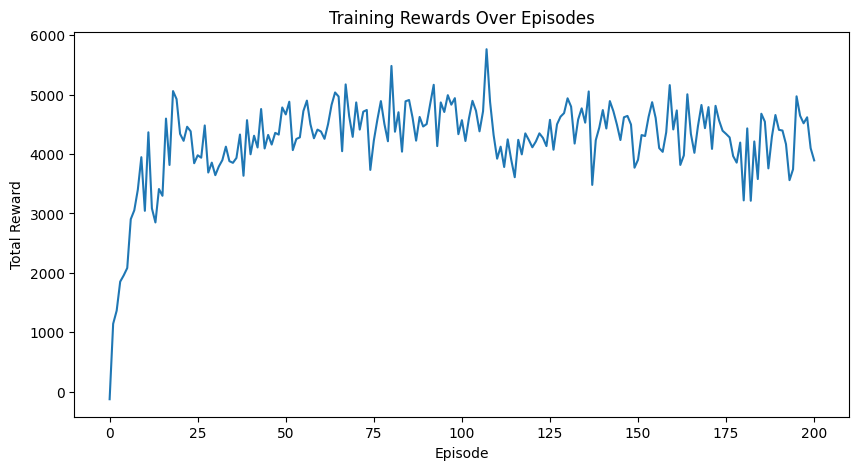

Training Episodes:  30%|███       | 300/1000 [08:36<18:50,  1.61s/it]

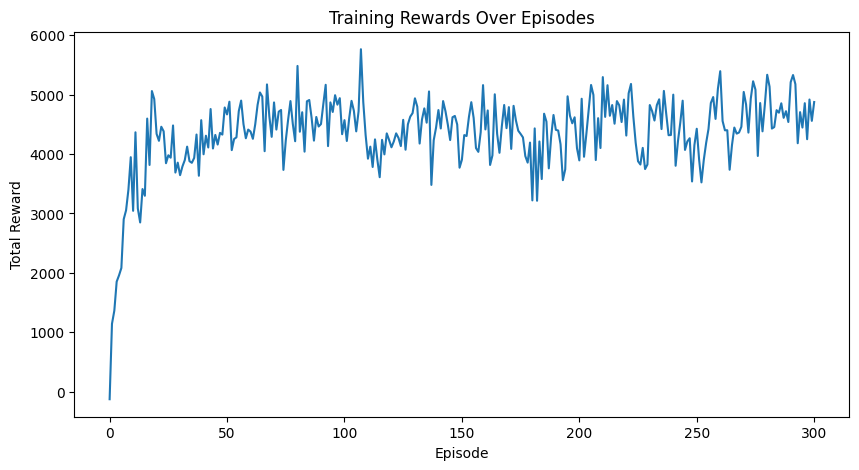

Training Episodes:  40%|████      | 400/1000 [11:34<16:15,  1.63s/it]

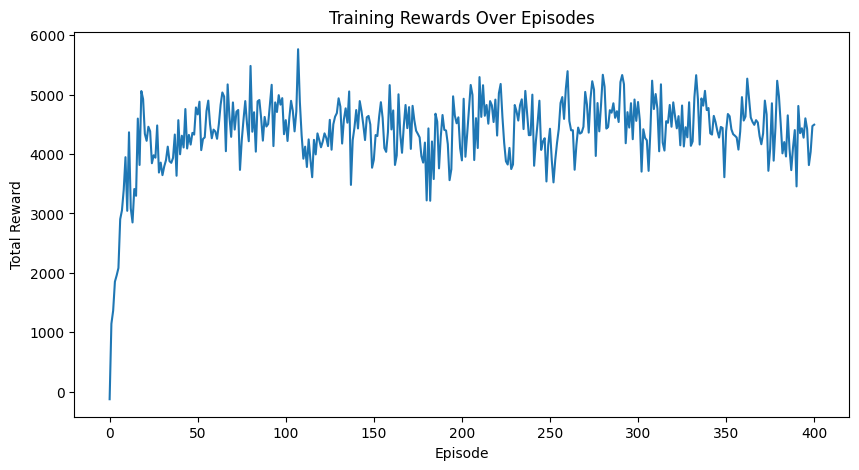

Training Episodes:  50%|█████     | 500/1000 [14:14<13:30,  1.62s/it]

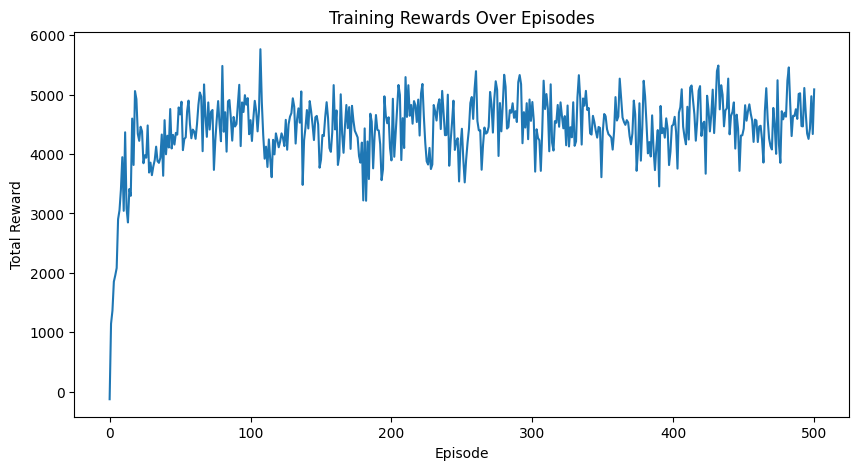

Training Episodes:  60%|██████    | 600/1000 [16:55<10:53,  1.63s/it]

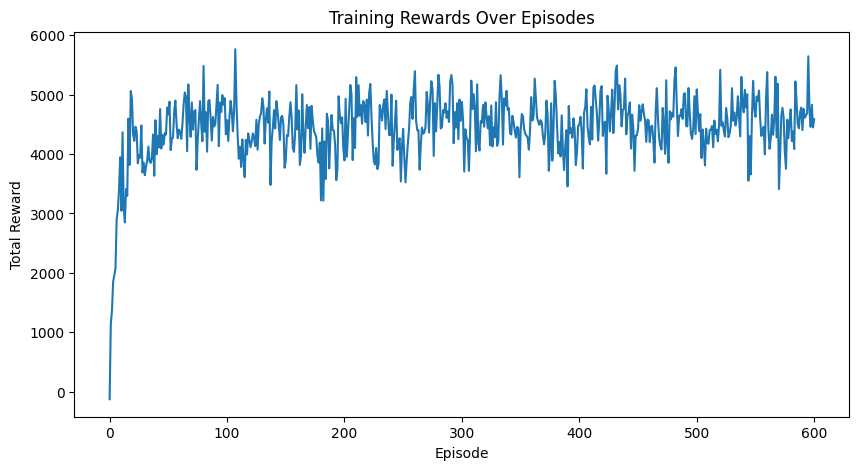

Training Episodes:  70%|███████   | 700/1000 [19:36<07:56,  1.59s/it]

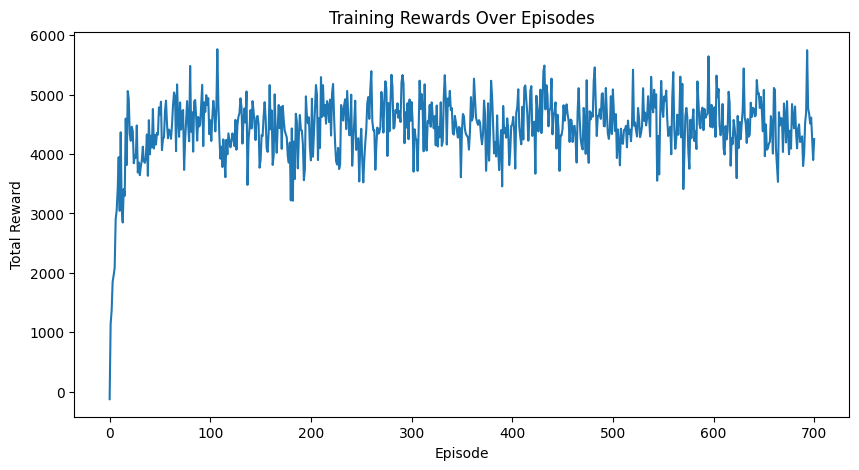

Training Episodes:  80%|████████  | 800/1000 [22:38<05:56,  1.78s/it]

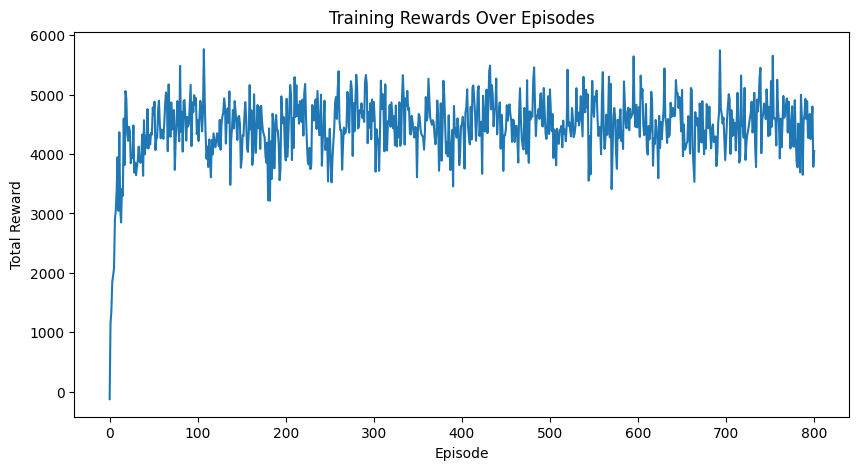

Training Episodes:  90%|█████████ | 900/1000 [25:57<03:35,  2.15s/it]

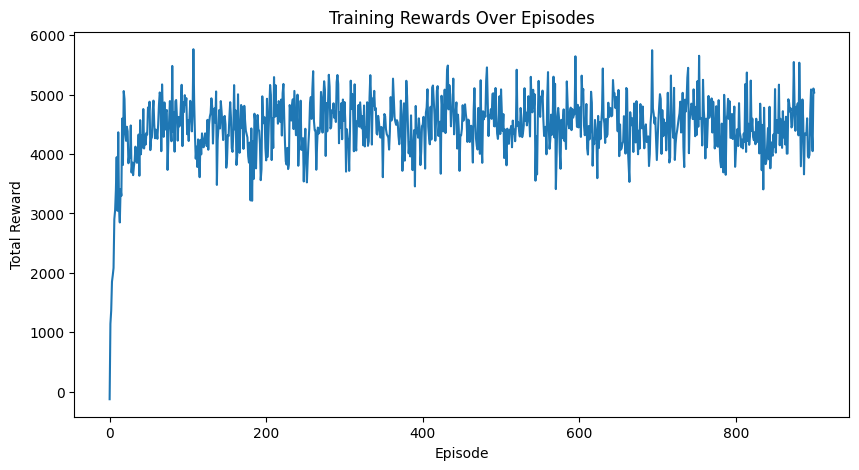

Training Episodes: 100%|██████████| 1000/1000 [29:51<00:00,  1.79s/it]


Training finished and Q-table saved.



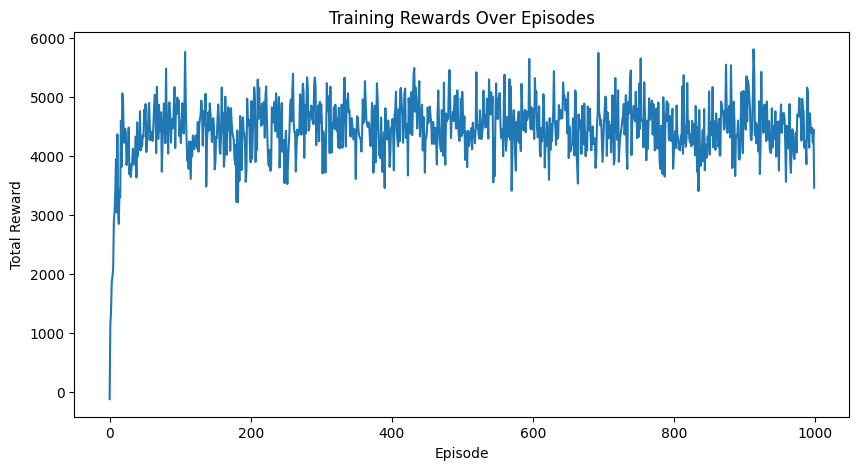

Total reward: 5668.100402832031


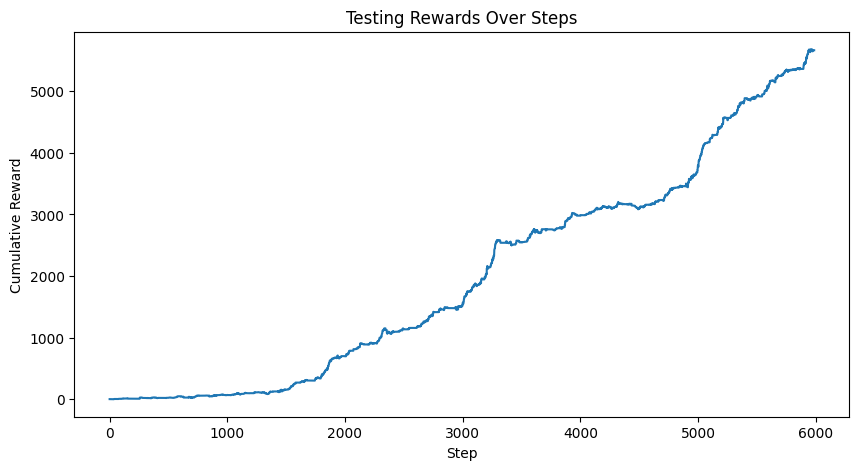

In [ ]:
import os
import pickle
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Function to download daily data for Gold from Yahoo Finance
def download_daily_data(symbol, period='max'):
    data = yf.download(tickers=symbol, interval='1d', period=period)
    data.reset_index(inplace=True)
    if 'Date' in data.columns:
        data.rename(columns={'Date': 'timestamp'}, inplace=True)
    else:
        print("Error: Could not find Date column in downloaded data.")
        return None

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    return data

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'].str.replace(',', ''), errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    else:
        print(f"Error: Failed to fetch data for {series_id}. Status code: {response.status_code}")
        return None

# Replace with your FRED API key
fred_api_key = 'xxx'

# Step 1: Download daily data for Gold
symbol = 'GC=F'  # Gold futures symbol
daily_data = download_daily_data(symbol)

# Step 2: Download macroeconomic data from FRED
series_ids = ['CPIAUCSL', 'PPIACO', 'PCEPI', 'HOUST']  # Added PCE and HOUST
fred_data = [download_fred_data(series_id, fred_api_key) for series_id in series_ids]
macro_data = pd.concat(fred_data, axis=1)

# Merge macroeconomic data with daily Gold data
# We need to forward fill macroeconomic data to align it with daily data timestamps
macro_data_ffill = macro_data.resample('D').ffill().reindex(daily_data.index, method='ffill')
data = daily_data.join(macro_data_ffill)

# Handle missing values before normalization
data.fillna(method='ffill', inplace=True)  # Forward fill missing values
data.fillna(method='bfill', inplace=True)  # Backfill any remaining missing values

# Select relevant features to reduce state space size
selected_features = ['Close', 'Low', 'CPIAUCSL', 'PPIACO', 'PCEPI', 'HOUST']
data = data[selected_features]

# Generate trading signals based on macroeconomic data
data['CPIAUCSL_signal'] = (data['CPIAUCSL'].diff() > 0).astype(int)
data['PPIACO_signal'] = (data['PPIACO'].diff() > 0).astype(int)
data['PCEPI_signal'] = (data['PCEPI'].diff() > 0).astype(int)
data['HOUST_signal'] = (data['HOUST'].diff() < 0).astype(int)

# Backtest strategy
initial_balance = 100000
results = {}
signals = ['CPIAUCSL_signal', 'PPIACO_signal', 'PCEPI_signal', 'HOUST_signal']

for signal in signals:
    balance = initial_balance
    position = 0
    total_trades = 0
    win_trades = 0
    loss_trades = 0
    total_profit = 0
    highest_win = -np.inf
    highest_loss = np.inf
    drawdown = 0
    peak_balance = initial_balance
    balance_history = []

    for date, row in data.iterrows():
        if position == 0:  # No open position
            if row[signal] == 1:
                # Determine direction
                if signal == 'HOUST_signal':
                    position_size = -balance * 0.1
                else:
                    position_size = balance * 0.1
                entry_price = row['Close']
                position = position_size / entry_price
                stop_loss = row['Low']
                take_profit = entry_price + 2 * (entry_price - stop_loss)
                total_trades += 1
        else:  # Position is open
            current_price = row['Close']
            if (position > 0 and current_price >= take_profit) or (position < 0 and current_price <= stop_loss):
                profit = position * (current_price - entry_price)
                balance += profit
                total_profit += profit
                if profit > 0:
                    win_trades += 1
                    highest_win = max(highest_win, profit)
                else:
                    loss_trades += 1
                    highest_loss = min(highest_loss, profit)
                position = 0

        peak_balance = max(peak_balance, balance)
        drawdown = max(drawdown, (peak_balance - balance) / peak_balance)
        balance_history.append(balance)

    win_percent = (win_trades / total_trades) * 100 if total_trades > 0 else 0
    results[signal] = {
        'final_balance': balance,
        'total_profit': total_profit,
        'total_trades': total_trades,
        'win_trades': win_trades,
        'loss_trades': loss_trades,
        'win_percent': win_percent,
        'highest_win': highest_win,
        'highest_loss': highest_loss,
        'max_drawdown': drawdown,
        'balance_history': balance_history
    }

# Plot the balance history for each macroeconomic indicator
plt.figure(figsize=(14, 8))
for signal in signals:
    plt.plot(data.index, results[signal]['balance_history'], label=f'{signal} strategy')
plt.title('Backtest Balance Over Time for Different Macroeconomic Indicators')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Print results
for signal, metrics in results.items():
    print(f"Results for {signal} strategy:")
    print(f"  Final balance: ${metrics['final_balance']:.2f}")
    print(f"  Total profit: ${metrics['total_profit']:.2f}")
    print(f"  Total trades: {metrics['total_trades']}")
    print(f"  Win trades: {metrics['win_trades']}")
    print(f"  Loss trades: {metrics['loss_trades']}")
    print(f"  Win percentage: {metrics['win_percent']:.2f}%")
    print(f"  Highest win: ${metrics['highest_win']:.2f}")
    print(f"  Highest loss: ${metrics['highest_loss']:.2f}")
    print(f"  Max drawdown: {metrics['max_drawdown']*100:.2f}%")
    print()

# Integrate signals into the RL environment
class TradingEnvWithSignals(gym.Env):
    def __init__(self, data):
        super(TradingEnvWithSignals, self).__init__()
        self.data = data
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(data.shape[1],))
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0  # Reset to the start if we reach the end

        reward = 0
        done = self.current_step >= len(self.data) - 1
        obs = self.data.iloc[self.current_step].values

        if action == 1:  # Buy
            reward = self.data['Close'].iloc[self.current_step] - self.data['Close'].iloc[self.current_step - 1]
        elif action == 2:  # Sell
            reward = self.data['Close'].iloc[self.current_step - 1] - self.data['Close'].iloc[self.current_step]

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass

env = TradingEnvWithSignals(data)

# Q-learning parameters
num_states = 3
num_state_combinations = num_states ** env.observation_space.shape[0]

# Check if the number of states is too large
if num_state_combinations > 1e6:
    raise MemoryError(f"Number of state combinations ({num_state_combinations}) is too large for Q-learning. Consider reducing num_states or the number of features.")

# Function to save Q-table
def save_q_table(q_table, filename='q_table.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

# Function to load Q-table
def load_q_table(filename='q_table.pkl'):
    if os.path.exists(filename) and os.path.getsize(filename) > 0:  # Check if file exists and is not empty
        with open(filename, 'rb') as f:
            return pickle.load(f)
    else:
        return np.zeros([num_state_combinations, env.action_space.n])

q_table = load_q_table()

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

rewards = []

# Training the Q-learning model with progress bar
for episode in tqdm(range(1000), desc="Training Episodes"):
    state = env.reset()
    discrete_state = np.clip((state * num_states).astype(int) % num_states, 0, num_states - 1)
    state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])
    done = False
    total_reward = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state_index])  # Exploit learned values

        next_state, reward, done, _ = env.step(action)
        next_discrete_state = np.clip((next_state * num_states).astype(int) % num_states, 0, num_states - 1)
        next_state_index = np.ravel_multi_index(next_discrete_state, [num_states] * env.observation_space.shape[0])

        old_value = q_table[state_index, action]
        next_max = np.max(q_table[next_state_index])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_index, action] = new_value

        state = next_state
        state_index = next_state_index
        total_reward += reward

    rewards.append(total_reward)

    # Save progress every 100 episodes
    if episode % 100 == 0:
        save_q_table(q_table)
        # Visualize partial results
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title('Training Rewards Over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

save_q_table(q_table)
print("Training finished and Q-table saved.\n")

# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Testing the trained model
state = env.reset()
discrete_state = np.clip((state * num_states).astype(int) % num_states, 0, num_states - 1)
state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])
done = False
total_reward = 0

test_rewards = []

while not done:
    action = np.argmax(q_table[state_index])
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    state = next_state
    discrete_state = np.clip((state * num_states).astype(int) % num_states, 0, num_states - 1)
    state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])

    test_rewards.append(total_reward)

print(f"Total reward: {total_reward}")

# Plot testing rewards
plt.figure(figsize=(10, 5))
plt.plot(test_rewards)
plt.title('Testing Rewards Over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.show()